# Тональный анализ отзывов на телефоны с Ситилинка

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
from nltk.corpus import stopwords
from sklearn import model_selection, metrics
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import (
    RandomForestClassifier, 
    BaggingClassifier,
    AdaBoostClassifier
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pymystem3 import Mystem
from string import punctuation

## Первичный анализ
### Данные сохранены в MongoDB

In [2]:
client = MongoClient()
db = client.opinions_db
collection = db.opinions

In [3]:
data = []
for value in collection.find():
    data.append([value['rate'], value['advantages'], value['disadvantages'], value['comment']])
columns = ['rate', 'advantages', 'disadvantages', 'comment']

In [4]:
df = pd.DataFrame(data, columns=columns)
df.head()

,rate,advantages,disadvantages,comment
0,5,Быстрый Удобный в пользовании Быстрый FaceID В...,На задней панели остается очень много отпечатк...,Это мой первый iOS смартфон. И после трех неде...
1,5,"дизайн, корпус, айОС, долговечность, надёжност...","камера сильно выступает из корпуса, придется д...",Покупкой полностью доволен!!!
2,5,"Приятный цвет, удобно лежит в руке. Существенн...",Нужен чехол для неаккуратный людей. Так как ст...,Купил для девушки. Всем довольна. Нареканий не...
3,5,"-Процессор А12 бионик. очень быстрый, приложен...",-Скользкий. ВНИМАНИЕ Руки автора отзыва могут ...,До Xr пользовался 5S. Разница колоссальная во ...
4,5,- Очень живучая батарея. Это первый мой iPhone...,- Все пишут про 3D touch. Я тоже напишу. Его н...,Apple выпустила еще одну модель про которую ещ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rate           1640 non-null   int64 
 1   advantages     1640 non-null   object
 2   disadvantages  1640 non-null   object
 3   comment        1640 non-null   object
dtypes: int64(1), object(3)
memory usage: 51.4+ KB


<AxesSubplot:>

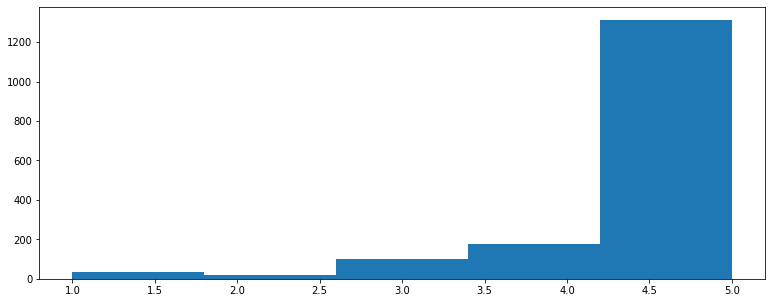

In [6]:
df['rate'].hist(grid=False, bins=5, figsize=(13, 5))

## Подготовка данных

In [7]:
df['text'] = df['advantages'] + ' ' + df['disadvantages'] + ' ' + df['comment']
df.head()

,rate,advantages,disadvantages,comment,text
0,5,Быстрый Удобный в пользовании Быстрый FaceID В...,На задней панели остается очень много отпечатк...,Это мой первый iOS смартфон. И после трех неде...,Быстрый Удобный в пользовании Быстрый FaceID В...
1,5,"дизайн, корпус, айОС, долговечность, надёжност...","камера сильно выступает из корпуса, придется д...",Покупкой полностью доволен!!!,"дизайн, корпус, айОС, долговечность, надёжност..."
2,5,"Приятный цвет, удобно лежит в руке. Существенн...",Нужен чехол для неаккуратный людей. Так как ст...,Купил для девушки. Всем довольна. Нареканий не...,"Приятный цвет, удобно лежит в руке. Существенн..."
3,5,"-Процессор А12 бионик. очень быстрый, приложен...",-Скользкий. ВНИМАНИЕ Руки автора отзыва могут ...,До Xr пользовался 5S. Разница колоссальная во ...,"-Процессор А12 бионик. очень быстрый, приложен..."
4,5,- Очень живучая батарея. Это первый мой iPhone...,- Все пишут про 3D touch. Я тоже напишу. Его н...,Apple выпустила еще одну модель про которую ещ...,- Очень живучая батарея. Это первый мой iPhone...


In [8]:
mystem = Mystem()
STOPWORDS = stopwords.words('russian')

def preprocess_text(text):
    tokens = mystem.lemmatize(text)
    return ' '.join([token for token in tokens if token not in STOPWORDS\
           and token != ' '\
           and token.strip() not in punctuation\
           and not token.isnumeric()\
           and token != '\xa0— '\
           and '«' not in token and '»' not in token])

df['text'] = [preprocess_text(text) for text in df['text']]

In [9]:
df.head()

,rate,advantages,disadvantages,comment,text
0,5,Быстрый Удобный в пользовании Быстрый FaceID В...,На задней панели остается очень много отпечатк...,Это мой первый iOS смартфон. И после трех неде...,быстрый удобный пользование быстрый FaceID впо...
1,5,"дизайн, корпус, айОС, долговечность, надёжност...","камера сильно выступает из корпуса, придется д...",Покупкой полностью доволен!!!,дизайн корпус айос долговечность надежность бе...
2,5,"Приятный цвет, удобно лежит в руке. Существенн...",Нужен чехол для неаккуратный людей. Так как ст...,Купил для девушки. Всем довольна. Нареканий не...,приятный цвет удобно лежать рука существенно ш...
3,5,"-Процессор А12 бионик. очень быстрый, приложен...",-Скользкий. ВНИМАНИЕ Руки автора отзыва могут ...,До Xr пользовался 5S. Разница колоссальная во ...,процессор А12 бионика очень быстрый приложение...
4,5,- Очень живучая батарея. Это первый мой iPhone...,- Все пишут про 3D touch. Я тоже напишу. Его н...,Apple выпустила еще одну модель про которую ещ...,очень живучий батарея это первый iPhone живучи...


In [10]:
# Here by some reason the kernel dies, so maybe I'll return to it later
# pos_cloud = WordCloud(width=3000, 
#                       height=2000, 
#                       random_state=1
#                      ).generate(''.join(df.loc[df['rate'] >= 4]['text']))
# neg_cloud = WordCloud(width=3000, 
#                       height=2000, 
#                       random_state=1
#                      ).generate(''.join(df.loc[df['rate'] < 3]['text']))
# fig, axes = plt.subplots(1, 2, figsize=(5, 5))
# axes[0].imshow(pos_cloud)
# axes[0].axis('off')
# axes[1].imshow(neg_cloud)
# axes[1].axis('off')

## Построение модели
Отзыв считается плохим, если оценка меньше 3-х звёзд. Так положительных отзывов намного больше, будет целесообразным обозначить негативные отзывы 0.

In [11]:
Y = np.array([1 if rate <= 3 else 0 for rate in df['rate']])
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['text'], Y)

In [12]:
print(train_y.shape, test_y.shape)

(1230,) (410,)


(array([373.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  37.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

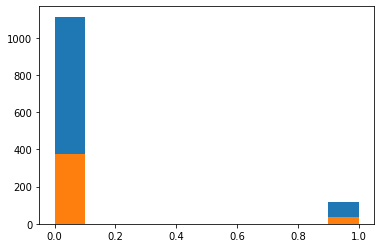

In [13]:
fig, axes = plt.subplots(1, 1)
axes.hist(train_y)
axes.hist(test_y)

### Метрики
Так как датасет не сбалансированный, необходимо использовать precision и recall
![Confusion Matrix](https://miro.medium.com/max/2400/1*OhEnS-T54Cz0YSTl_c3Dwg.jpeg)
$$ accuracy = \frac{T_p + T_n}{T_p + T_n + F_p + F_n} $$ - отношение верных предсказаний ко всем предсказаниям. В данном случае даст недостоверные показания, так как единиц намного больше
$$ precision = \frac{T_p}{T_p + F_p} $$ - отношение верно предсказанных единиц ко всем предсказанным единицам
$$ recall = \frac{T_p}{T_p + F_n} $$ - отношение верно предсказанных единиц к числу эталонных единиц
$$ F_1 = 2 * \frac{Pr * Re}{Pr + Re} $$ - среднее гармоническое precision и recall

In [23]:
def print_scores(predictions, expected):
    print('-------------')
    print(f'accuracy=[{metrics.accuracy_score(predictions, expected)}]')
    print(f'precision=[{metrics.precision_score(predictions, expected)}]')
    print(f'recall=[{metrics.recall_score(predictions, expected)}]')
    print(f'F1=[{metrics.f1_score(predictions, expected)}]')
    print('-------------')

### Count Vectors

In [15]:
count_vect = CountVectorizer()
count_vect.fit(train_x)

xtrain_count = count_vect.transform(train_x)
xtest_count = count_vect.transform(test_x)

### TF-IDF Vectors

In [16]:
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(train_x)

xtrain_tfidf = tfidf_vect.transform(train_x)
xtest_tfidf = tfidf_vect.transform(test_x)

## Naive Bayes

In [24]:
model = MultinomialNB()
model.fit(xtrain_count, train_y)
predictions = model.predict(xtest_count)
print('Count Vectors')
print_scores(predictions, test_y)

model = MultinomialNB()
model.fit(xtrain_tfidf, train_y)
predictions = model.predict(xtest_tfidf)
print('TF-IDF Vectors')
print_scores(predictions, test_y)

Count Vectors
-------------
accuracy=[0.9097560975609756]
precision=[0.05405405405405406]
recall=[0.5]
F1=[0.0975609756097561]
-------------
TF-IDF Vectors
-------------
accuracy=[0.9097560975609756]
precision=[0.0]
recall=[0.0]
F1=[0.0]
-------------


/home/ginkul/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest

In [25]:
model = RandomForestClassifier()
model.fit(xtrain_count, train_y)
predictions = model.predict(xtest_count)
print('Count Vectors')
print_scores(predictions, test_y)

model = RandomForestClassifier()
model.fit(xtrain_tfidf, train_y)
predictions = model.predict(xtest_tfidf)
print('TF-IDF Vectors')
print_scores(predictions, test_y)

Count Vectors
-------------
accuracy=[0.9121951219512195]
precision=[0.02702702702702703]
recall=[1.0]
F1=[0.052631578947368425]
-------------
TF-IDF Vectors
-------------
accuracy=[0.9097560975609756]
precision=[0.02702702702702703]
recall=[0.5]
F1=[0.05128205128205129]
-------------


## Logistic Regression

In [32]:
model = LogisticRegression()
model.fit(xtrain_count, train_y)
predictions = model.predict(xtest_count)
print('Count Vectors')
print_scores(predictions, test_y)

model = LogisticRegression()
model.fit(xtrain_tfidf, train_y)
predictions = model.predict(xtest_tfidf)
print('Count Vectors')
print_scores(predictions, test_y)

Count Vectors
-------------
accuracy=[0.9073170731707317]
precision=[0.08108108108108109]
recall=[0.42857142857142855]
F1=[0.13636363636363638]
-------------
Count Vectors
-------------
accuracy=[0.9097560975609756]
precision=[0.0]
recall=[0.0]
F1=[0.0]
-------------


/home/ginkul/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Bagging Model

In [43]:
model = BaggingClassifier()
model.fit(xtrain_count, train_y)
predictions = model.predict(xtest_count)
print('Count Vectors')
print_scores(predictions, test_y)

model = BaggingClassifier()
model.fit(xtrain_tfidf, train_y)
predictions = model.predict(xtest_tfidf)
print('Count Vectors')
print_scores(predictions, test_y)

Count Vectors
-------------
accuracy=[0.9146341463414634]
precision=[0.16216216216216217]
recall=[0.6]
F1=[0.25531914893617025]
-------------
Count Vectors
-------------
accuracy=[0.9024390243902439]
precision=[0.16216216216216217]
recall=[0.4]
F1=[0.23076923076923078]
-------------


## Boosting Model

In [41]:
model = AdaBoostClassifier(n_estimators=500)
model.fit(xtrain_count, train_y)
predictions = model.predict(xtest_count)
print('Count Vectors')
print_scores(predictions, test_y)

model = AdaBoostClassifier(n_estimators=500)
model.fit(xtrain_tfidf, train_y)
predictions = model.predict(xtest_tfidf)
print('Count Vectors')
print_scores(predictions, test_y)

Count Vectors
-------------
accuracy=[0.8951219512195122]
precision=[0.24324324324324326]
recall=[0.375]
F1=[0.2950819672131148]
-------------
Count Vectors
-------------
accuracy=[0.8902439024390244]
precision=[0.21621621621621623]
recall=[0.3333333333333333]
F1=[0.26229508196721313]
-------------
